# __For the sake of completeness...__

...let's perform the whole train / test procedure onto our train and test sets. Remember that the training / validation sets which involved all our time features including lags and which was devoid of any non-time features performed among the best. Its performance was equivalent to the train / validation set including all time and non-time features. Yet, to keep overfitting at a minimum it is best to go for the training set with less features in case of equivalent performances.

In [1]:
import pandas as pd
import numpy as np

import joblib
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

__Remember that we saved our test set after data imputation. So in terms of processing we will have to add all time features before attempting predictions on it. Also let's have a look at it again:__

In [2]:
train = pd.read_pickle('../../data/train.pkl')
test = pd.read_pickle('../../data/test.pkl')

In [3]:
train.drop(columns='Price', inplace=True)
train.head()

,CO2E_EMISSIONS_FACTOR
2009-07-01 04:00:00,0.991217
2009-07-01 04:05:00,0.000000
2009-07-01 04:10:00,0.000000
2009-07-01 04:15:00,0.991217
2009-07-01 04:20:00,1.025701


In [4]:
test.drop(columns='Price', inplace=True)
test.head()

,CO2E_EMISSIONS_FACTOR
2018-06-01 00:00:00,0.605679
2018-06-01 00:05:00,0.912643
2018-06-01 00:10:00,0.605679
2018-06-01 00:15:00,0.912643
2018-06-01 00:20:00,0.908305


In [5]:
assert train.index.max() < test.index.min()

__Wasn't there something else about the test set?__

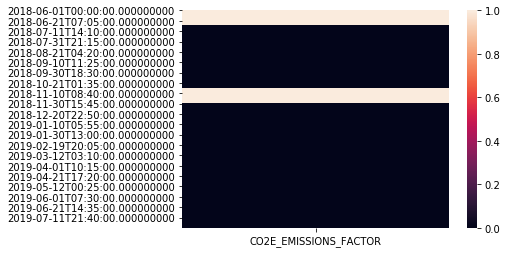

<Figure size 864x360 with 0 Axes>

In [6]:
fig = sns.heatmap(test.isnull())
plt.figure(figsize=(12,5));

__Right, we could not quite fill in two very big gaps of 1 month periods each time. Refresh your memory by refering back to the notebook 'data imputation' if you need to.__

The first gap is not a problem, as we can cut it straight out without further considerations. This also takes care of data leakage from our training / validation set into our test set (refer to notebook 'grid search'). Here, we will also just drop the 2nd 1 month bundle of missing data. This is not quite accurate as this is going to introduce some inaccuracies around that NaN region in terms of our lagging features. But considering the massive size of our test set (+120.000 samples), we will consider that negligible here.

In [7]:
def time_columns(df):
    
    df = df.copy()
    
    df.loc[:,'minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['weekday'] = np.where(df.index.weekday < 5, 0, 1)
    df['month'] = df.index.month
    df['year'] = df.index.year

    df['minute_sin'] = np.sin(2 * np.pi * df.loc[:,'minute']/60)
    df['minute_cos'] = np.cos(2 * np.pi * df.loc[:,'minute']/60)

    df['hour_sin'] = np.sin(2 * np.pi * df.loc[:,'hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df.loc[:,'hour']/24)
    
    df['month_sin'] = np.sin(2 * np.pi * df.loc[:,'month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df.loc[:,'month']/12)
    
    df.drop(columns=['minute', 'hour', 'month'], inplace=True)
    
    return df

In [8]:
def lag_horizon(df, lag, horizon):
    '''
    Returns dataset with additional features defined by lag and modified target defined by horizon
    lag=integer of how far back time series should look
    horizon=integer of how far into the future the model shall predict; horizon=0 means prediciton 1 step into future
    '''
    df = df.copy()
    
    for i in range(1,lag+1):
        df[f'lag{i}'] = df['CO2E_EMISSIONS_FACTOR'].shift(i)
    
    for i in range(1,horizon+2):
        df[f'horizon{i-1}'] = df['CO2E_EMISSIONS_FACTOR'][lag:]
        
    return df

In [9]:
def errors(model, X_train, y_train, X_test, y_test):

    train_mae = (sum(abs(y_train - model.predict(X_train)))/len(y_train))
    train_mape = (sum(abs((y_train - model.predict(X_train))/y_train)))*(100/len(y_train))
    train_smape = sum(abs(y_train - model.predict(X_train)))/sum(y_train + model.predict(X_train))

    test_mae = (sum(abs(y_test - model.predict(X_test)))/len(y_test))
    test_mape = (sum(abs((y_test - model.predict(X_test))/y_test)))*(100/len(y_test))
    test_smape = sum(abs(y_test - model.predict(X_test)))/sum(y_test + model.predict(X_test))

    print(f'train_MAE: {train_mae}')
    print(f'test_MAE: {test_mae}')
    
    print(f'train_MAPE: {train_mape}')
    print(f'test_MAPE: {test_mape}')
    
    print(f'train_SMAPE: {train_smape}')
    print(f'test_SMAPE: {test_smape}')

### __Addition of time features into train and test sets__

In [10]:
train = time_columns(train)
train = lag_horizon(train, 12, 0)
train.columns

Index(['CO2E_EMISSIONS_FACTOR', 'weekday', 'year', 'minute_sin', 'minute_cos',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag1', 'lag2',
       'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10',
       'lag11', 'lag12', 'horizon0'],
      dtype='object')

In [11]:
# we have to drop any NaNs that emerged while introducing the lagging features (refer to previous notebook)

train.dropna(inplace=True)

In [12]:
test = time_columns(test)
test = lag_horizon(test, 12, 0)
test.columns

Index(['CO2E_EMISSIONS_FACTOR', 'weekday', 'year', 'minute_sin', 'minute_cos',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag1', 'lag2',
       'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10',
       'lag11', 'lag12', 'horizon0'],
      dtype='object')

In [13]:
# here, we do not only loose any NaNs from time feature intro but also the ones from the 2 1 month gaps

test.dropna(inplace=True)

### __Splitting train and test sets into features and target__

In [14]:
X_train = train.drop(columns=['CO2E_EMISSIONS_FACTOR', 'horizon0'])
y_train = train.CO2E_EMISSIONS_FACTOR

In [15]:
X_test = test.drop(columns=['CO2E_EMISSIONS_FACTOR', 'horizon0'])
y_test = test.CO2E_EMISSIONS_FACTOR

In [16]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105478 entries, 2018-06-01 01:00:00 to 2019-08-01 03:55:00
Data columns (total 20 columns):
weekday       105478 non-null int64
year          105478 non-null int64
minute_sin    105478 non-null float64
minute_cos    105478 non-null float64
hour_sin      105478 non-null float64
hour_cos      105478 non-null float64
month_sin     105478 non-null float64
month_cos     105478 non-null float64
lag1          105478 non-null float64
lag2          105478 non-null float64
lag3          105478 non-null float64
lag4          105478 non-null float64
lag5          105478 non-null float64
lag6          105478 non-null float64
lag7          105478 non-null float64
lag8          105478 non-null float64
lag9          105478 non-null float64
lag10         105478 non-null float64
lag11         105478 non-null float64
lag12         105478 non-null float64
dtypes: float64(18), int64(2)
memory usage: 16.9 MB


### __Model training__

We now train an xgboost tree with our entire training dataset. Note that in the train / validation trials, the models were always only trained with a subset of the training set.

In [19]:
model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)

[17:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=7, nthread=None, num_estimators=100, objective='reg:linear',
             random_state=0, reg_alpha=0.05, reg_lambda=0, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### __Let's see how all that will work out here:__

In [20]:
errors(model, X_train, y_train, X_test, y_test)

train_MAE: 0.1990048307092955
test_MAE: 0.23168326956281773
train_MAPE: inf
test_MAPE: inf
train_SMAPE: 0.14420805534854753
test_SMAPE: 0.20058151424324855


__We get similar error metrics with our train / test set as we got for our train validation set for the same set of features. Overfitting is slightly increased but still moderate.__

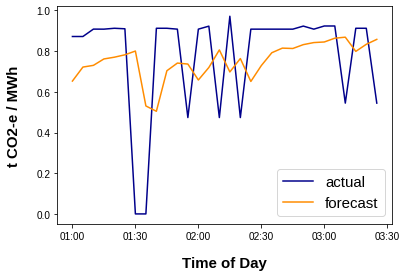

In [22]:
fig = plt.plot_date(y_test.index[:30], y_test.iloc[:30], linestyle='solid', marker=None, color='darkblue', label="actual")
fig = plt.plot_date(y_test.index[:30], model.predict(X_test)[:30], linestyle='solid', marker=None, color='darkorange', label="forecast")
plt.legend(fontsize=15)

plt.xlabel("Time of Day", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

plt.style.use('seaborn')

__Not surprsingly, we do get the same qualitative outcome as with our train / validation that we do cannot actually forecast any values but rather our algorithm learned to look back onto the previous value to make its predictions.__